In [1]:
from bs4 import BeautifulSoup
import requests
import math
import pandas as pd
import patsy

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.pipeline import make_pipeline

import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

### Acquiring data 

Sources we acquired from are www.sa.aqar.fm and www.propertyfinder.sa

In [3]:
villas=[]
widths1=[]
i=1

while i<10:
    url = f"https://sa.aqar.fm/%D9%81%D9%84%D9%84-%D9%84%D9%84%D8%A8%D9%8A%D8%B9/{i}"
    res=requests.get(url)
    if res.status_code==200:
        p=res.text
        soup=BeautifulSoup(p,"lxml")
        i+=1
        
        houses=soup.find_all("div", {"class":"titleAndDetails"})
        headers = ["Price", "#Bedrooms", "#Bathrooms", "Size(m²)","District"]
        for house in houses:
            price = float(house.find(class_="price").text.replace("ريال", "").replace(",", "").strip())
            bed = int(house.find(class_="bed").text.strip())
            bath = int(house.find(class_="bath").text.strip())
            size = float(house.find(class_="size").text.replace("م²", "").strip())
            districts = house.find(class_="locText").text.strip()
            house_dict = dict(zip(headers, [price, bed, bath, size, districts]))
            villas.append(house_dict)
            
        URL= soup.find_all("a",class_="listTitle")
        for h in URL:
            pageurl="https://sa.aqar.fm"+h["href"]
            resp=requests.get(pageurl)
            hpage= resp.text
            hsoup=BeautifulSoup(hpage, "lxml")
            table=hsoup.find("table",class_="dc-detailsTable")
            rows=table.find_all("tr")
            
            for row in rows:
                if "الشارع" in row.text:
                    x=int(row.find_all("td")[0].text.replace("م", "").strip())
                    widths1.append(x)
    else:
        break

In [4]:
len(villas)

180

In [5]:
len(widths1)

176

In [7]:
from statistics import mean

ele=1

while ele<(len(villas)-len(widths1)+1):
    widths1.append(int(mean(widths1)))
    ele+=1

In [8]:
len(widths1)

180

In [128]:
villaDF=pd.DataFrame(villas)

In [129]:
villaDF["StreetWidth"]=widths1

In [130]:
villaDF

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
0,1350000.0,7,5,455.0,حي طويق - المزاحمية,20
1,1900000.0,5,5,1200.0,حي اللؤلؤ - الخبر,20
2,1025000.0,7,5,315.0,حي المعمورة - خميس مشيط,15
3,2400000.0,7,5,750.0,حي الرمال - الرياض,25
4,1350000.0,7,5,300.0,حي نمار - الرياض,15
...,...,...,...,...,...,...
175,950000.0,4,4,300.0,حي طويق - الرياض,25
176,1850000.0,5,5,320.0,حي النرجس - الرياض,18
177,1020000.0,5,5,220.0,حي طويق - الرياض,18
178,6000000.0,5,5,1800.0,حي الفيحاء - الرياض,18


In [131]:
villaDF= villaDF[villaDF.District.str.contains("الرياض") == True]
villaDF

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
3,2400000.0,7,5,750.0,حي الرمال - الرياض,25
4,1350000.0,7,5,300.0,حي نمار - الرياض,15
5,7500000.0,7,5,1902.0,حي الربوة - الرياض,20
7,1650000.0,5,3,312.0,حي المونسية - الرياض,20
9,3000000.0,7,5,676.0,حي المحمدية - الرياض,15
...,...,...,...,...,...,...
174,1750000.0,7,5,300.0,حي جامعة الامام محمد بن سعود الاسلامية - الرياض,100
175,950000.0,4,4,300.0,حي طويق - الرياض,25
176,1850000.0,5,5,320.0,حي النرجس - الرياض,18
177,1020000.0,5,5,220.0,حي طويق - الرياض,18


In [132]:
villaDF= villaDF[villaDF.District.str.contains("حي الرياض - جدة") == False]
villaDF

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
3,2400000.0,7,5,750.0,حي الرمال - الرياض,25
4,1350000.0,7,5,300.0,حي نمار - الرياض,15
5,7500000.0,7,5,1902.0,حي الربوة - الرياض,20
7,1650000.0,5,3,312.0,حي المونسية - الرياض,20
9,3000000.0,7,5,676.0,حي المحمدية - الرياض,15
...,...,...,...,...,...,...
174,1750000.0,7,5,300.0,حي جامعة الامام محمد بن سعود الاسلامية - الرياض,100
175,950000.0,4,4,300.0,حي طويق - الرياض,25
176,1850000.0,5,5,320.0,حي النرجس - الرياض,18
177,1020000.0,5,5,220.0,حي طويق - الرياض,18


In [9]:
houses_list = []
widths=[]

i = 1
while i < 50:
    url = f"https://sa.aqar.fm/%D8%A8%D9%8A%D8%AA-%D9%84%D9%84%D8%A8%D9%8A%D8%B9/%D8%A7%D9%84%D8%B1%D9%8A%D8%A7%D8%B6/{i}" 
    response = requests.get(url)
    if response.status_code == 200:
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        i += 1
        houses=soup.find_all("div", {"class":"titleAndDetails"})
        headers = ["Price", "#Bedrooms", "#Bathrooms", "Size(m²)","District"]
        for house in houses:
            price = float(house.find(class_="price").text.replace("ريال", "").replace(",", "").strip())
            bed = int(house.find(class_="bed").text.strip())
            bath = int(house.find(class_="bath").text.strip())
            size = float(house.find(class_="size").text.replace("م²", "").strip())
            districts = house.find(class_="locText").text.strip()
            house_dict = dict(zip(headers, [price, bed, bath, size, districts]))
            houses_list.append(house_dict)
            
        URL= soup.find_all("a",class_="listTitle")
        for h in URL:
            pageurl="https://sa.aqar.fm"+h["href"]
            resp=requests.get(pageurl)
            hpage= resp.text
            hsoup=BeautifulSoup(hpage, "lxml")
            table=hsoup.find("table",class_="dc-detailsTable")
            rows=table.find_all("tr")
            
            for row in rows:
                if "الشارع" in row.text:
                    x=int(row.find_all("td")[0].text.replace("م", "").strip())
                    widths.append(x)
    else:
        break

In [10]:
len(houses_list)

977

In [11]:
len(widths)

899

In [13]:

e=1

while e < (len(houses_list)-len(widths)+1):
    widths.append(int(mean(widths)))
    e+=1

In [14]:
len(widths)

977

In [133]:
df = pd.DataFrame(houses_list)
df.head()

,Price,#Bedrooms,#Bathrooms,Size(m²),District
0,580000.0,5,5,250.0,حي العزيزية - الرياض
1,400000.0,5,5,600.0,حي المناخ - الرياض
2,1450000.0,5,4,480.0,حي طويق - الرياض
3,300000.0,5,5,213.0,حي الصالحية - الرياض
4,900000.0,5,5,375.0,حي الدار البيضاء - الرياض


In [134]:
df["StreetWidth"]=widths
df

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
0,580000.0,5,5,250.0,حي العزيزية - الرياض,15
1,400000.0,5,5,600.0,حي المناخ - الرياض,20
2,1450000.0,5,4,480.0,حي طويق - الرياض,15
3,300000.0,5,5,213.0,حي الصالحية - الرياض,8
4,900000.0,5,5,375.0,حي الدار البيضاء - الرياض,5
...,...,...,...,...,...,...
972,750000.0,5,5,400.0,حي العريجاء الغربية - الرياض,16
973,2500000.0,5,5,816.0,حي الخليج - الرياض,16
974,1150000.0,5,4,390.0,حي طويق - الرياض,16
975,500000.0,5,2,140.0,حي السويدي - الرياض,16


In [22]:
houses_list2 = []
i = 1
while i < 56:
    url_2 = f"https://www.propertyfinder.sa/ar/search?bf=1&btf=1&c=1&l=4&ob=mr&page={i}&t=35" 
    response2 = requests.get(url_2)
    if response2.status_code == 200:
        page2 = response2.text
        soup2 = BeautifulSoup(page2, "lxml")
        i += 1
        houses2=soup2.find_all("div", {"class":"card-list__item"})
        headers2 = ["Price", "#Bedrooms", "#Bathrooms", "Size(m²)","District"]
        for house in houses2:
            price = float(house.find(class_="card__price-value").text.replace("ريال", "").replace(",", "").strip())
            bed = house.find(class_="card__property-amenity card__property-amenity--bedrooms").text.replace("+", "").replace("عدد الغرف","").strip()
            bath = house.find(class_="card__property-amenity card__property-amenity--bathrooms").text.replace("+", "").replace("حمامات","").strip()
            size = float(house.find(class_="card__property-amenity card__property-amenity--area").text.replace("متر مربع", "").replace(",", "").strip())
            districts = house.find(class_="card__location-text").text.replace("حي الملقا","الملقا").strip()
            house_dict = dict(zip(headers, [price, bed, bath, size, districts]))
            houses_list2.append(house_dict)
    else:
        break

In [23]:
len(houses_list2)

1362

In [135]:
df2 = pd.DataFrame(houses_list2)

In [136]:
df3 = pd.concat([df, df2,villaDF])
df3

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
0,580000.0,5,5,250.0,حي العزيزية - الرياض,15.0
1,400000.0,5,5,600.0,حي المناخ - الرياض,20.0
2,1450000.0,5,4,480.0,حي طويق - الرياض,15.0
3,300000.0,5,5,213.0,حي الصالحية - الرياض,8.0
4,900000.0,5,5,375.0,حي الدار البيضاء - الرياض,5.0
...,...,...,...,...,...,...
174,1750000.0,7,5,300.0,حي جامعة الامام محمد بن سعود الاسلامية - الرياض,100.0
175,950000.0,4,4,300.0,حي طويق - الرياض,25.0
176,1850000.0,5,5,320.0,حي النرجس - الرياض,18.0
177,1020000.0,5,5,220.0,حي طويق - الرياض,18.0


### Data Pre Processing 
(EDA, Cleaning)

In [138]:
df3.isna().sum()

Price             0
#Bedrooms         0
#Bathrooms        0
Size(m²)          0
District          0
StreetWidth    1362
dtype: int64

In [139]:
df3["StreetWidth"].fillna(df3["StreetWidth"].median(), inplace = True)

In [140]:
df3.isna().sum()

Price          0
#Bedrooms      0
#Bathrooms     0
Size(m²)       0
District       0
StreetWidth    0
dtype: int64

In [141]:
df3["StreetWidth"].isna().sum()

0

In [142]:
df3.head()

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
0,580000.0,5,5,250.0,حي العزيزية - الرياض,15.0
1,400000.0,5,5,600.0,حي المناخ - الرياض,20.0
2,1450000.0,5,4,480.0,حي طويق - الرياض,15.0
3,300000.0,5,5,213.0,حي الصالحية - الرياض,8.0
4,900000.0,5,5,375.0,حي الدار البيضاء - الرياض,5.0


In [143]:
df3['District'] = df3['District'].str.split(" - ", n = 1, expand = True)
df3

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
0,580000.0,5,5,250.0,حي العزيزية,15.0
1,400000.0,5,5,600.0,حي المناخ,20.0
2,1450000.0,5,4,480.0,حي طويق,15.0
3,300000.0,5,5,213.0,حي الصالحية,8.0
4,900000.0,5,5,375.0,حي الدار البيضاء,5.0
...,...,...,...,...,...,...
174,1750000.0,7,5,300.0,حي جامعة الامام محمد بن سعود الاسلامية,100.0
175,950000.0,4,4,300.0,حي طويق,25.0
176,1850000.0,5,5,320.0,حي النرجس,18.0
177,1020000.0,5,5,220.0,حي طويق,18.0


In [144]:
df3['District'] = df3['District'].str.split(", ", n = 1, expand = True)
df3

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
0,580000.0,5,5,250.0,حي العزيزية,15.0
1,400000.0,5,5,600.0,حي المناخ,20.0
2,1450000.0,5,4,480.0,حي طويق,15.0
3,300000.0,5,5,213.0,حي الصالحية,8.0
4,900000.0,5,5,375.0,حي الدار البيضاء,5.0
...,...,...,...,...,...,...
174,1750000.0,7,5,300.0,حي جامعة الامام محمد بن سعود الاسلامية,100.0
175,950000.0,4,4,300.0,حي طويق,25.0
176,1850000.0,5,5,320.0,حي النرجس,18.0
177,1020000.0,5,5,220.0,حي طويق,18.0


In [145]:
df3['District'] = df3['District'].str.replace("حي ", "")
df3

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
0,580000.0,5,5,250.0,العزيزية,15.0
1,400000.0,5,5,600.0,المناخ,20.0
2,1450000.0,5,4,480.0,طويق,15.0
3,300000.0,5,5,213.0,الصالحية,8.0
4,900000.0,5,5,375.0,الدار البيضاء,5.0
...,...,...,...,...,...,...
174,1750000.0,7,5,300.0,جامعة الامام محمد بن سعود الاسلامية,100.0
175,950000.0,4,4,300.0,طويق,25.0
176,1850000.0,5,5,320.0,النرجس,18.0
177,1020000.0,5,5,220.0,طويق,18.0


In [146]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2442 entries, 0 to 178
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        2442 non-null   float64
 1   #Bedrooms    2442 non-null   object 
 2   #Bathrooms   2442 non-null   object 
 3   Size(m²)     2442 non-null   float64
 4   District     2442 non-null   object 
 5   StreetWidth  2442 non-null   float64
dtypes: float64(3), object(3)
memory usage: 133.5+ KB


In [147]:
df3.shape

(2442, 6)

In [148]:
df3.sample(4)

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
901,1850000.0,5,6,360.0,الرمال,15.0
778,1350000.0,3,5,360.0,المهدية,15.0
109,6000000.0,5,7,625.0,الملقا,15.0
154,1400000.0,5,5,360.0,طويق,15.0


In [149]:
df3['#Bedrooms'] = df3['#Bedrooms'].astype(float, errors = 'raise')
df3['#Bathrooms'] = df3['#Bathrooms'].astype(float, errors = 'raise')
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2442 entries, 0 to 178
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        2442 non-null   float64
 1   #Bedrooms    2442 non-null   float64
 2   #Bathrooms   2442 non-null   float64
 3   Size(m²)     2442 non-null   float64
 4   District     2442 non-null   object 
 5   StreetWidth  2442 non-null   float64
dtypes: float64(5), object(1)
memory usage: 133.5+ KB


In [150]:
df3['District'].value_counts().head(10)

الرمال           349
طويق             275
المونسية         201
القادسية         124
الملقا            86
اليرموك           80
الدار البيضاء     62
بدر               55
النرجس            54
النظيم            52
Name: District, dtype: int64

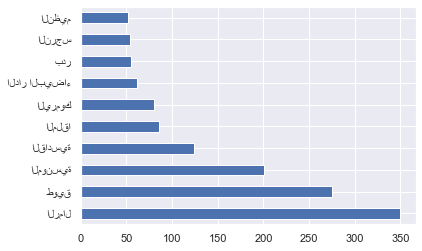

In [151]:
df3['District'].value_counts()[:10].plot(kind='barh');

In [152]:
top_Dis =df3[['District' ,'Price']].groupby('District').mean().reset_index().sort_values(by = 'Price', ascending = False)
top_Dis.head(10)

,District,Price
16,الخزامى,1.400000e+07
125,مركز الملك عبدالله للدراسات والبحوث,1.000000e+07
119,عرقة,8.330000e+06
20,الرائد,6.000000e+06
71,الملقا,5.981977e+06
47,العليا,5.823077e+06
50,الغدير,5.750000e+06
91,الواحة,5.750000e+06
108,حطين,5.698333e+06
105,جامعة الملك سعود,5.500000e+06


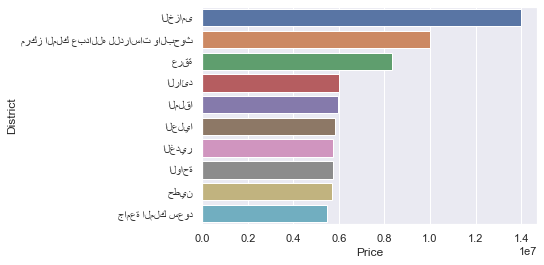

In [153]:
sns.barplot(data=top_Dis.head(10), x='Price',y='District', palette = 'deep');

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 5.894588
Kurtosis: 62.427960


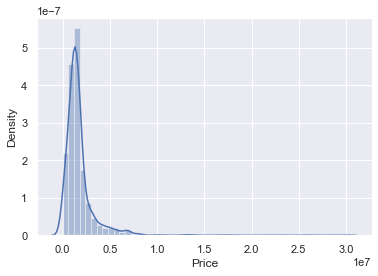

In [154]:
sns.distplot(df3['Price']);
#skewness and kurtosis
print("Skewness: %f" % df3['Price'].skew())
print("Kurtosis: %f" % df3['Price'].kurt())

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


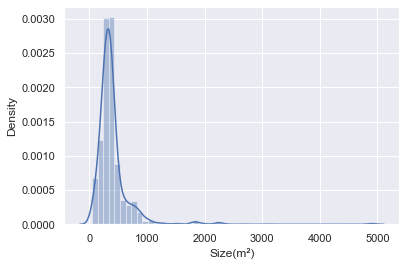

In [156]:
sns.distplot(df3['Size(m²)']);

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


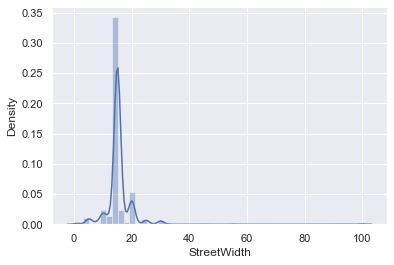

In [157]:
sns.distplot(df3['StreetWidth']);

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


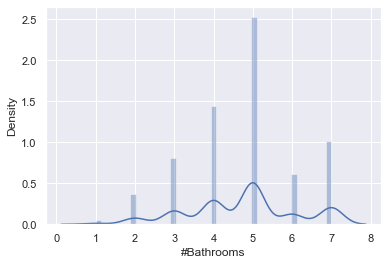

In [158]:
sns.distplot(df3['#Bathrooms']);

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


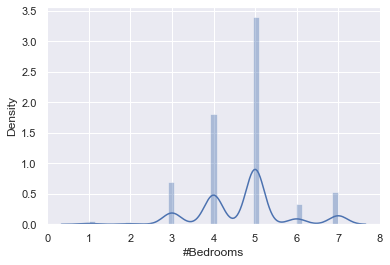

In [159]:
sns.distplot(df3['#Bedrooms']);

In [160]:
df3.describe()

,Price,#Bedrooms,#Bathrooms,Size(m²),StreetWidth
count,2.442000e+03,2442.000000,2442.000000,2442.000000,2442.000000
mean,1.736941e+06,4.690827,4.739967,406.224406,15.580262
std,1.759264e+06,1.046555,1.387585,339.859018,5.216680
min,3.750000e+02,1.000000,1.000000,50.000000,1.000000
25%,9.500000e+05,4.000000,4.000000,260.000000,15.000000
50%,1.350000e+06,5.000000,5.000000,350.000000,15.000000
75%,1.850000e+06,5.000000,5.000000,420.000000,15.000000
max,3.000000e+07,7.000000,7.000000,4900.000000,100.000000


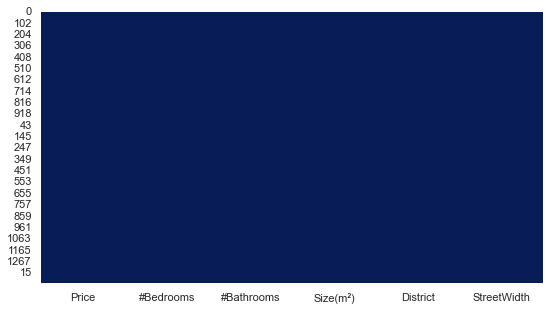

In [161]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(df3.isnull(), cbar=False, cmap="YlGnBu_r")#check if there is any null values
plt.show()

Insight: No nulls

In [258]:
df3.corr()

,Price,#Bedrooms,#Bathrooms,Size(m²),StreetWidth
Price,1.000000,0.103925,0.422856,0.409663,0.022888
#Bedrooms,0.103925,1.000000,0.383695,0.054567,0.021604
#Bathrooms,0.422856,0.383695,1.000000,0.243299,0.043465
Size(m²),0.409663,0.054567,0.243299,1.000000,0.044212
StreetWidth,0.022888,0.021604,0.043465,0.044212,1.000000


In [163]:
df3.cov()

,Price,#Bedrooms,#Bathrooms,Size(m²),StreetWidth
Price,3.095008e+12,344165.126555,794877.574569,3.087576e+08,110701.087799
#Bedrooms,3.441651e+05,1.095278,0.716786,4.138936e+01,0.111470
#Bathrooms,7.948776e+05,0.716786,1.925391,8.510754e+01,-0.030124
Size(m²),3.087576e+08,41.389360,85.107537,1.155042e+05,88.185586
StreetWidth,1.107011e+05,0.111470,-0.030124,8.818559e+01,27.213752


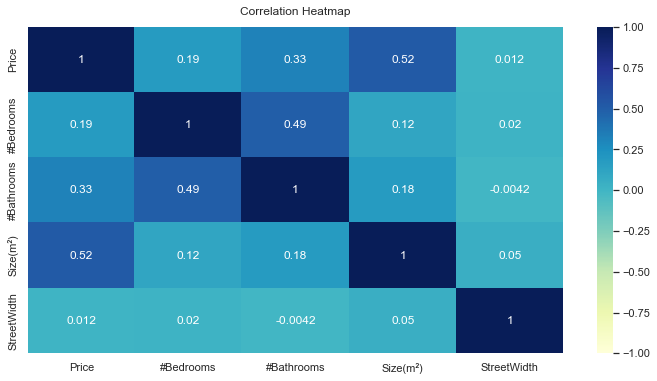

In [164]:
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df3.corr(), vmin=-1, vmax=1, annot=True,cmap="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

- The "Size" feature has high positive correlation 0.52 with our target "Price"
- The "Bathrooms" feature has positive correlation 0.33 with our target "Price"
- The "Bedrooms" feature has low positive correlation 0.19 with our target "Price"

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


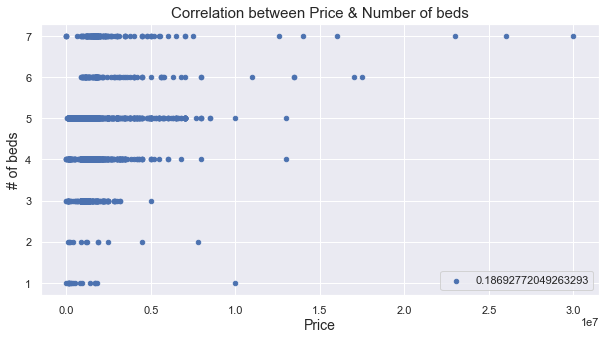

In [165]:
corr = df3["Price"].corr(df3['#Bedrooms']) 
df3.plot(kind="scatter",y="#Bedrooms" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Number of beds" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("# of beds" , fontsize=14)
plt.legend();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


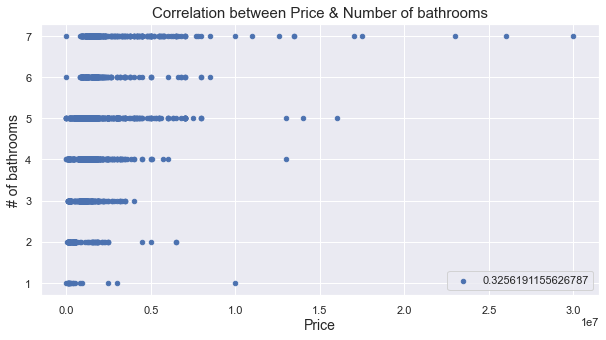

In [166]:
corr = df3['Price'].corr(df3['#Bathrooms']) 
df3.plot(kind="scatter",y="#Bathrooms" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Number of bathrooms" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("# of bathrooms" , fontsize=14)
plt.legend();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


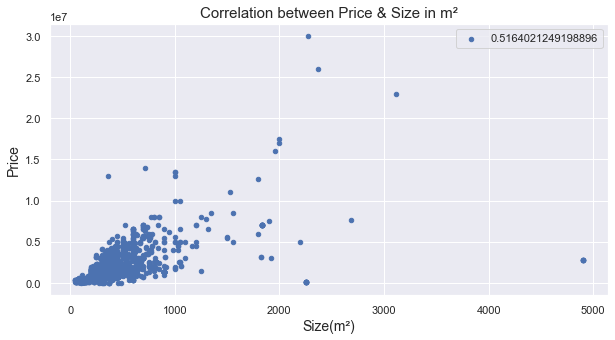

In [167]:
corr = df3['Price'].corr(df3['Size(m²)']) 
df3.plot(kind="scatter",y="Price" , x="Size(m²)",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Size in m²" , fontsize=15)
plt.xlabel("Size(m²)" , fontsize=14)
plt.ylabel("Price" , fontsize=14)
plt.legend();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


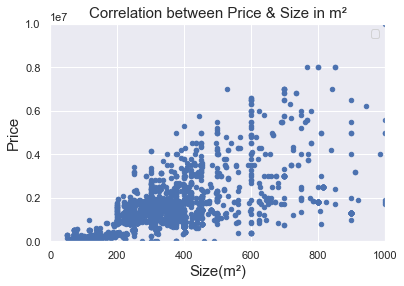

In [168]:
#Zoomed in plot for the price vs size(m2)

df3.plot(x="Size(m²)", y='Price', kind='scatter')
plt.xlim([0, 1000])
plt.ylim([0,1e7])
plt.title("Correlation between Price & Size in m²" , fontsize=15)
plt.xlabel("Size(m²)" , fontsize=15)
plt.ylabel("Price" , fontsize=15)
plt.legend();

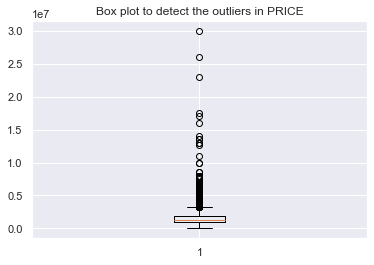

In [169]:
plt.boxplot(df3["Price"])
plt.title("Box plot to detect the outliers in PRICE")
plt.show()

In [182]:
df3.Price.describe()

count    2.442000e+03
mean     1.736941e+06
std      1.759264e+06
min      3.750000e+02
25%      9.500000e+05
50%      1.350000e+06
75%      1.850000e+06
max      3.000000e+07
Name: Price, dtype: float64

In [212]:
df3[df3.index.duplicated()]

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
0,1550000.0,4.0,6.0,389.0,الرمال,15.0
1,3000000.0,4.0,6.0,375.0,قرطبة,15.0
2,1300000.0,4.0,5.0,225.0,الرمال,15.0
3,950000.0,6.0,6.0,300.0,طويق,15.0
4,1900000.0,7.0,7.0,375.0,الرمال,15.0
...,...,...,...,...,...,...
174,1750000.0,7.0,5.0,300.0,جامعة الامام محمد بن سعود الاسلامية,100.0
175,950000.0,4.0,4.0,300.0,طويق,25.0
176,1850000.0,5.0,5.0,320.0,النرجس,18.0
177,1020000.0,5.0,5.0,220.0,طويق,18.0


In [212]:
df3[df3.index.duplicated()]

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
0,1550000.0,4.0,6.0,389.0,الرمال,15.0
1,3000000.0,4.0,6.0,375.0,قرطبة,15.0
2,1300000.0,4.0,5.0,225.0,الرمال,15.0
3,950000.0,6.0,6.0,300.0,طويق,15.0
4,1900000.0,7.0,7.0,375.0,الرمال,15.0
...,...,...,...,...,...,...
174,1750000.0,7.0,5.0,300.0,جامعة الامام محمد بن سعود الاسلامية,100.0
175,950000.0,4.0,4.0,300.0,طويق,25.0
176,1850000.0,5.0,5.0,320.0,النرجس,18.0
177,1020000.0,5.0,5.0,220.0,طويق,18.0


In [211]:
df3.columns.duplicated().any()

False

In [214]:
df3= df3.loc[~df3.index.duplicated(), :]

In [215]:
df3.shape

(1362, 6)

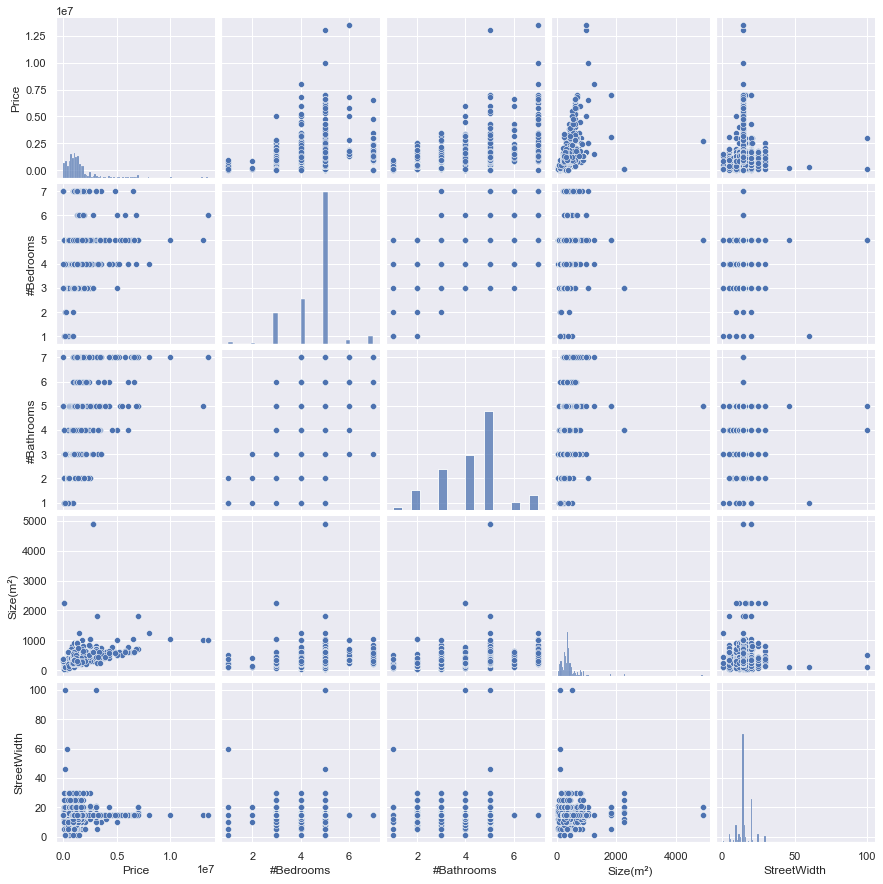

In [227]:
sns.pairplot(df3);

**Make a copy of dataframe**

In [228]:
DF=df3.copy()

Encode the District feature to be able to feed the model

In [229]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
DF['District'] = labelencoder.fit_transform(DF['District'])

In [230]:
DF.head()

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
0,580000.0,5.0,5.0,250.0,27,15.0
1,400000.0,5.0,5.0,600.0,45,20.0
2,1450000.0,5.0,4.0,480.0,72,15.0
3,300000.0,5.0,5.0,213.0,21,8.0
4,900000.0,5.0,5.0,375.0,10,5.0


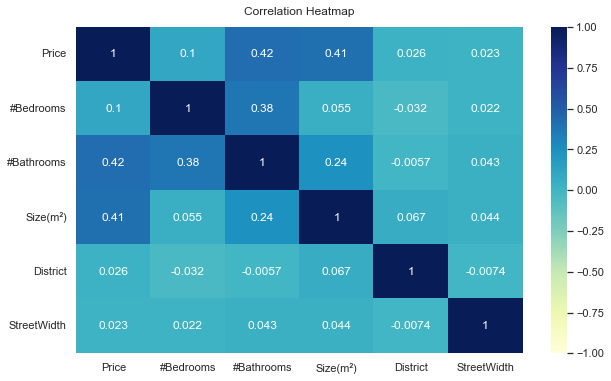

In [231]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(DF.corr(), vmin=-1, vmax=1, annot=True,cmap="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

**Trying to add log function to enhance the correlations between Price and other features: Street width, bedrooms, bathrooms**

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


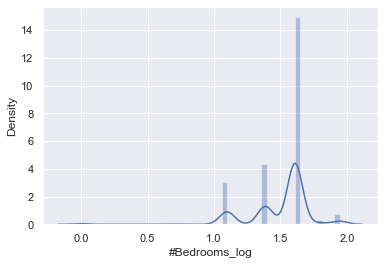

In [259]:
DF['#Bedrooms_log'] = np.log(DF['#Bedrooms'])
sns.distplot(DF['#Bedrooms_log']);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


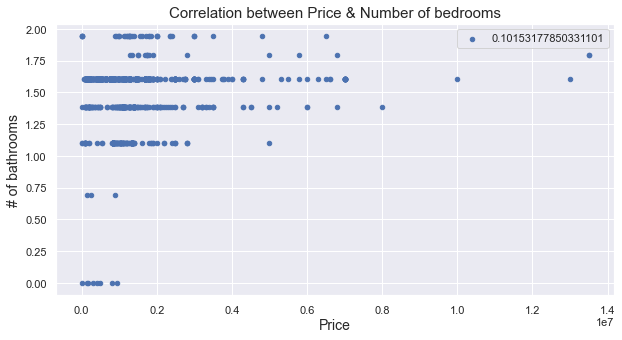

In [238]:
corr = DF['Price'].corr(DF['#Bedrooms_log']) 
DF.plot(kind="scatter",y="#Bedrooms_log" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Number of bedrooms" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("# of bathrooms" , fontsize=14)
plt.legend();

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


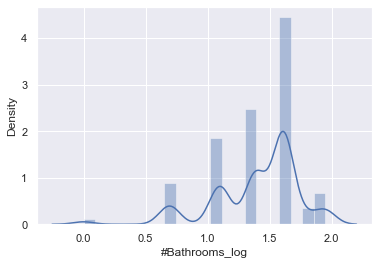

In [234]:
DF['#Bathrooms_log'] = np.log(DF['#Bathrooms'])
sns.distplot(DF['#Bathrooms_log']);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


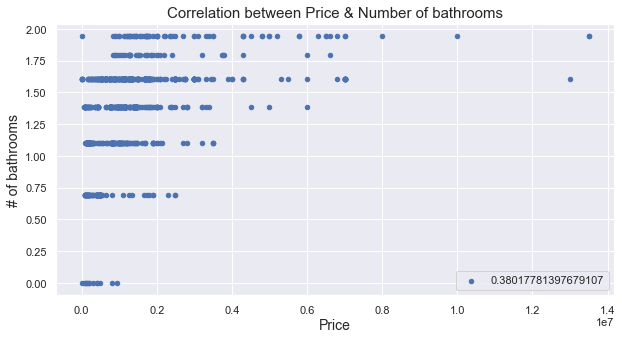

In [235]:
corr = DF['Price'].corr(DF['#Bathrooms_log']) 
DF.plot(kind="scatter",y="#Bathrooms_log" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Number of bathrooms" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("# of bathrooms" , fontsize=14)
plt.legend();

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


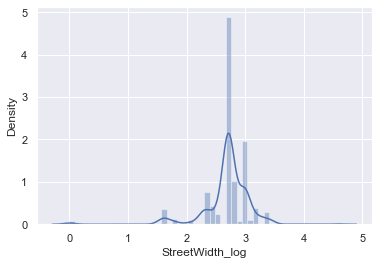

In [236]:
DF['StreetWidth_log'] = np.log(DF['StreetWidth'])
sns.distplot(DF['StreetWidth_log']);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


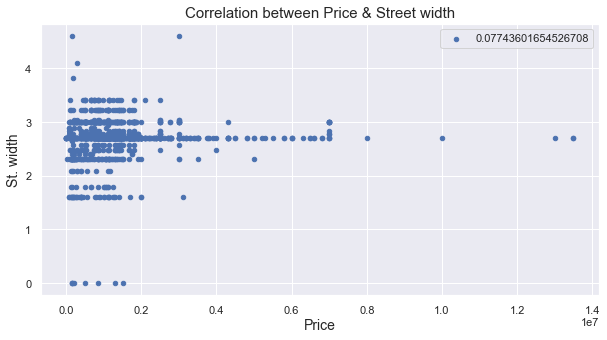

In [237]:
corr = DF['Price'].corr(DF['StreetWidth_log']) 
DF.plot(kind="scatter",y="StreetWidth_log" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Street width" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("St. width" , fontsize=14)
plt.legend();

**Result:**
- There is not much improvement except for the "StreetWidth"; the correlation was 0.023 and turn to 0.077, the rest of features had better correlation with Price before performing log()

### Modeling

In [239]:
# split into train and target
X,y = DF.iloc[:,1:],DF['Price']

In [240]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 0 to 1361
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   #Bedrooms        1172 non-null   float64
 1   #Bathrooms       1172 non-null   float64
 2   Size(m²)         1172 non-null   float64
 3   District         1172 non-null   int32  
 4   StreetWidth      1172 non-null   float64
 5   #Bedrooms_log    1172 non-null   float64
 6   #Bathrooms_log   1172 non-null   float64
 7   StreetWidth_log  1172 non-null   float64
dtypes: float64(7), int32(1)
memory usage: 77.8 KB


In [241]:
model = LinearRegression()

In [252]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''

     # perform train/val split
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=24) # "= \ to coinsder this line with the above one"
    
    # fit linear regression to training data
    lr_model = LinearRegression() 
    lr_model.fit(X_train, y_train)
    model=lr_model
    
    # fit Ridge regression 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)

    lm_reg = Ridge(alpha=2)
    lm_reg.fit(X_scaled,y)


    
    # score fit model on validation data
    val_score_linear = cross_val_score(lr_model, X, y, cv = 5).mean()
    val_score_rid = cross_val_score(lm_reg, X, y, cv = 5).mean()
    
    # report results

    print(f'Linear Regression test R²: {lr_model.score(X_test, y_test):.3f}')
    print('\nCross Validation for Linear model score:', val_score_linear)
    print(f'\nRidge Regression test R²: {lm_reg.score(X_test_scaled, y_test):.3f}')
    print('\nCross Validation for Ridge model score:', val_score_rid)

In [253]:
split_and_validate(X,y)

Linear Regression test R²: 0.389

Cross Validation for Linear model score: 0.11337469462991892

Ridge Regression test R²: 0.410

Cross Validation for Ridge model score: 0.13191434278182118


In [254]:
X2 = X.copy()

X2['Bedrooms'] = X2['#Bedrooms_log']
X2['Bathrooms'] = X2['#Bathrooms_log'] 

In [255]:
split_and_validate(X2,y)

Linear Regression test R²: 0.389

Cross Validation for Linear model score: 0.113374694629895

Ridge Regression test R²: 0.409

Cross Validation for Ridge model score: 0.13092700661998177


In [256]:
X5 = X2.copy()

X5['Size'] = X2['Size(m²)']**2 #adding quadretic terms

In [257]:
split_and_validate(X5,y)

Linear Regression test R²: 0.539

Cross Validation for Linear model score: 0.19877976323233668

Ridge Regression test R²: 0.560

Cross Validation for Ridge model score: 0.21477907901123924
